# Pre-process of tracks from Free Music Archive 

In [2]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import warnings
import gc
import os

from torchvision.transforms import Compose, ToTensor, RandomAffine, v2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tensorboard.backend.event_processing import event_accumulator
from sklearn import preprocessing
import pytorch_lightning as pl
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import random
import mgr.utils as utils
import mgr.utils_mgr as mgr

from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassF1Score, MulticlassAccuracy
import torcheval.metrics

2024-05-16 15:47:10.555605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Creation of Dataframe containing tracks metadata

In [4]:
# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')

#Check tracks format
tracks.shape 

(106574, 52)

In [5]:
#Select the desired subset among the entire dataset
sub = 'small'
raw_subset = tracks[tracks['set', 'subset'] <= sub] 

In [6]:
#This function create a dataframe containing index and label for a subset, simplifying its structure and making it suitable 
#for the split into test, validation and validation sets, moreover labels are converted into numpy arrays
def create_subset(raw_sub):
    labels = conv_label(raw_sub['track']['genre_top']) 
    subset = pd.DataFrame(columns = ['index', 'genre_top', 'split', 'labels'])
    
    for j in range(len(raw_sub['track'].index)):
        index = raw_sub['track'].index[j]
        genre = raw_sub['track', 'genre_top'][index]
        split = raw_sub['set', 'split'][index]
        label = labels[j]
        # Create a new row as a Series
        new_row = pd.Series({'index': index, 'genre_top': genre, 'split':split, 'labels':label})
        subset.loc[len(subset)] = new_row
        
    return subset


#Function to convert labels into array of probabilities
def conv_label(label):
    le = LabelEncoder()
    y = le.fit_transform(label)
    y = to_categorical(y, 8)
    return y

In [7]:
#Creation of clean subset for the generation of training, test and validation sets
meta_subset= create_subset(raw_subset)

# Remove corrupted files
corrupted = [98565, 98567, 98569, 99134, 108925, 133297]
meta_subset = meta_subset[~meta_subset['index'].isin(corrupted)]

meta_subset[:10]

,index,genre_top,split,labels
0,2,Hip-Hop,training,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
1,5,Hip-Hop,training,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,10,Pop,training,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,140,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,141,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,148,Experimental,validation,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,182,Rock,test,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
7,190,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,193,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,194,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [8]:
#Split between taining, validation and test set according to original FMA split
train_set = meta_subset[meta_subset["split"] == "training"]
val_set   = meta_subset[meta_subset["split"] == "validation"]
test_set  = meta_subset[meta_subset["split"] == "test"]

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(6394, 4)
(800, 4)
(800, 4)


# Audio

In [9]:
#Function to extract audio signal from .mp3 file
def getAudio(idx, sr_i=None, PATH_DATA="data/"):
    #Get the audio file path
    filename = utils.get_audio_path(PATH_DATA+"fma_small/", idx)

    #Load the audio (sr = sampling rate, number of audio carries per second)
    x, sr = librosa.load(filename, sr=sr_i, mono=True)  #sr=None to consider original sampling rate

    return x, sr

In [44]:
#Function getAudio to extract tracks from .mp3 file
audio_tot, sr = getAudio(2)


filename = utils.get_audio_path("data/fma_small", 2)
audio_tot, sr = librosa.load(filename, sr=None, mono=True)

#Print some track features
print('Sampling rate: ', sr)
duration_seconds = audio_tot.shape[0] / sr
print(f'Duration: {duration_seconds:.2f}s, {audio_tot.shape[0]} samples')

# Play random segment of the audio (Clip that will be used as Cnn input)
start = np.random.randint(0, (audio_tot.shape[0]-2**18))
audio = audio_tot[start:start+2**18]

Sampling rate:  44100
Duration: 29.98s, 1321967 samples


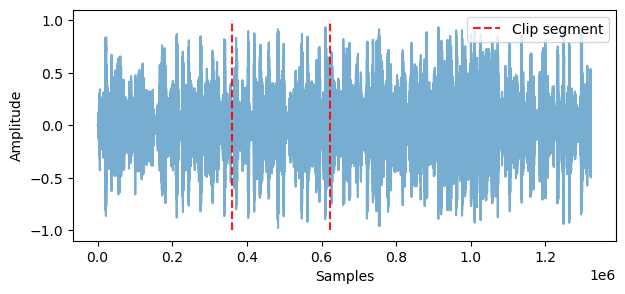

In [52]:
# Create another plot for a segment of the audio signal
plt.figure(figsize=(7, 3))
plt.plot(audio_tot, alpha =0.6) 
plt.vlines([start,start+2**18], -1, 1, color='r', alpha=0.9, linestyle='--', label='Clip segment')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#Legend at top right
plt.legend(loc='upper right')
plt.show()




# Compute stft and mel spectrogram


In [61]:
# Compute the short-time Fourier transform (stft)
stft = np.abs(librosa.stft(audio, n_fft=2048, hop_length=1024))


# Compute the mel spectrogram
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2, n_mels=128)[:,:256]
mel = librosa.power_to_db(mel)

print(mel.shape)

(128, 256)


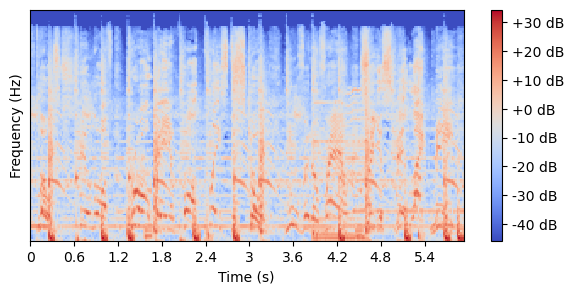

In [62]:
# Plot the log mel spectrogram for visualization purpose 
plt.figure(figsize=(7, 3))
librosa.display.specshow(mel, sr=sr, hop_length=1024, x_axis='time')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.colorbar(format='%+2.0f dB')
plt.show()

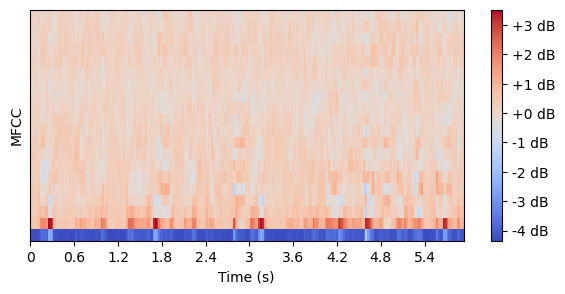

In [63]:
# Compute the MFCCs
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)

mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)

# Plot the MFCCs for visualization purpose
plt.figure(figsize=(7, 3))
librosa.display.specshow(mfcc, sr=sr, hop_length=1024,x_axis='time',  )
plt.colorbar(format='%+2.0f dB')
plt.ylabel('MFCC')
plt.xlabel('Time (s)')
plt.show()      

# Creation of Dataset class

In [ ]:
#Creation of custom class for the extraction of samples to be used as input for torch networks valid for both 1D and 2D networks


class DataAudio(Dataset):

    def __init__(self, df, transform = None, PATH_DATA="data/",  net_type = "1D", test = False, mfcc=False, normalize = False):
        
        # Get track index
        self.track_ids = df['index'].values

        #Get genre label
        self.label = df['labels'].values

        #Transform
        self.transform = transform

        #Select type of input
        self.type = net_type

        #Test
        self.test = test

        #Path to data
        self.path = PATH_DATA

        #mfcc
        self.mfcc = mfcc

        #Normalize
        self.normalize = normalize

    def __len__(self):

        return len(self.track_ids)


    def create_input(self, i):
      
        # Get audio        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            audio, sr = getAudio(self.track_ids[i], PATH_DATA = self.path)

            #If test select clip window starting at half of the audio
            if(self.test):
                start = int(audio.shape[0]/2)
                audio = audio[start:start+2**18]

            else:
                #Select random clip from audio
                start = np.random.randint(0, (audio.shape[0]-2**18))
                audio = audio[start:start+2**18]
                
            if (self.type=="2D"):
                #Get 2D spectrogram
                stft = np.abs(librosa.stft(audio, n_fft=2048, hop_length=1024))
                
                spect = librosa.feature.melspectrogram(sr=sr, S=stft**2, n_mels=128)[:,:256]

                if self.mfcc:
                    spect = librosa.feature.mfcc(S=librosa.power_to_db(spect), n_mfcc=20)
                    spect = spect.T
                    
                else:
                    spect = librosa.power_to_db(spect).T    

                return spect
            
            return audio[np.newaxis,:]      

    def __getitem__(self, idx):

        # get input and label
        try:
            x = self.create_input(idx)
            y = self.label[idx] 
        except:
            print("\nNot able to load track number ", self.track_ids[idx], " Loading next one\n")
            x = self.create_input(idx+1)
            y = self.label[idx+1]
        
        if self.normalize:
            #Scale data
            scaler = preprocessing.StandardScaler(copy=False)
            x = scaler.fit_transform(x)

        if self.transform:
            
            if self.type=="1D":
                # Audiogmentations library requires to specify the sample rate
                x = self.transform(x, 44100) 
            else:
                x = self.transform(x)
                
        return x,y
    


#DataAudio class for MixNet network with of 1D and 2D inputs

class DataAudioMix(Dataset):

    def __init__(self, df, transform = None, PATH_DATA="data/", test = False, mfcc=False, normalize = False):
        
        # Get track index
        self.track_ids = df['index'].values

        #Get genre label
        self.label = df['labels'].values

        #Transform
        self.transform = transform

        #Test
        self.test = test

        #Path to data
        self.path = PATH_DATA

        #mfcc
        self.mfcc = mfcc

        #Normalize
        self.normalize = normalize

    def __len__(self):

        return len(self.track_ids)


    def create_input(self, i):
      
        # Get audio
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            audio, sr = getAudio(self.track_ids[i], PATH_DATA = self.path)

            #If test select clip window starting at half of the audio
            if(self.test):
                start = int(audio.shape[0]/2)
                audio = audio[start:start+2**18]

            else:
                #Select random clip from audio
                start = np.random.randint(0, (audio.shape[0]-2**18))
                audio = audio[start:start+2**18]           

            #Get 2D spectrogram
            stft = np.abs(librosa.stft(audio, n_fft=2048, hop_length=1024))
            
            spect = librosa.feature.melspectrogram(sr=sr, S=stft**2, n_mels=128)[:,:256]

            if self.mfcc:
                spect = librosa.feature.mfcc(S=librosa.power_to_db(spect), n_mfcc=20)
                spect = spect.T
                
            else:
                spect = librosa.power_to_db(spect).T    

            
            return [audio[np.newaxis,:], spect]
        
    def __getitem__(self, idx):

        # get input and label
        try:
            x = self.create_input(idx)
            y = self.label[idx] 

        except:
            print("\nNot able to load track number ", self.track_ids[idx], " Loading next one\n")
            x = self.create_input(idx+1)
            y = self.label[idx+1]
        
        if self.normalize:
            #Scale data
            scaler = preprocessing.StandardScaler(copy=False)
            x[0] = scaler.fit_transform(x[0])
            x[1] = scaler.fit_transform(x[1])

    
        if self.transform['1D']:
            # Audiogmentations library requires to specify the sample rate
            x[0] = self.transform['1D'](x[0], 44100) 
        if self.transform['2D']:
            x[1] = self.transform['2D'](x[1])

        return x,y



# Pytorch Lightning module class

In [ ]:
# Define a general LightningModule (nn.Module subclass) 
class LitNet(pl.LightningModule):
    
    def __init__(self, model_net, optimizer = None, config_optimizer = None, schedule = False):
       
        super().__init__()
        
        print('Network initialized')
        
        self.net = model_net

        self.confusion_matrix_train = MulticlassConfusionMatrix(num_classes=8)
        self.confusion_matrix_val   = MulticlassConfusionMatrix(num_classes=8)
        self.confusion_matrix_test  = MulticlassConfusionMatrix(num_classes=8)

        self.confusion_matrix_train.persistent(True)
        self.confusion_matrix_val.persistent(True)

        self.f1_score_train = MulticlassF1Score(num_classes=8, average='macro')
        self.f1_score_val   = MulticlassF1Score(num_classes=8, average='macro')
        self.f1_score_test  = MulticlassF1Score(num_classes=8, average='macro')

        
        if optimizer is None:
                print("Using default optimizer parameters")
                self.optimizer = Adam(self.net.parameters(), lr = 1e-5)
        else:
            
            print("Using optimizer passed as argument")
            self.optimizer = optimizer

        try:
            self.schedule = schedule
            self.lr_step = config_optimizer["lr_step"]
            self.lr_gamma = config_optimizer["lr_gamma"]

            print("Using lr_step and lr_gamma from config_optimizer")

        except:
            self.schedule = False
            self.lr_step = 1
            self.lr_gamma = 0.0


    def forward(self,x):
        return self.net(x)

    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch     = batch[0]
        label_batch = batch[1]
        out         = self.net(x_batch)
        loss        = F.cross_entropy(out, label_batch) 
        
        #Estimation of model accuracy
        out_argmax = out.argmax(dim=1)
        label_argmax = label_batch.argmax(dim=1)

        self.log("train_loss", loss.item(), prog_bar=True,on_step=False,on_epoch=True)
        self.log("train_f1_score",self.f1_score_train(out_argmax, label_argmax), prog_bar=True,on_step=False,on_epoch=True)
        self.confusion_matrix_train.update(out_argmax, label_argmax)
  
        return loss
    
    def on_train_epoch_end(self):
        # Save the confusion matrix
        torch.save(self.confusion_matrix_train.state_dict(), "confusion_matrix_train.pth")
        print("computing confusion matrix")
        cm = self.confusion_matrix_train.compute()
        print(cm)

        # Compute accuracy
        correct_predictions = torch.diag(cm).sum().item()
        total_predictions = cm.sum().item()
        accuracy = correct_predictions / total_predictions
        self.log("train_acc", accuracy, prog_bar=True, on_step=False, on_epoch=True)

        print("Resetting confusion matrix")
        self.confusion_matrix_train.reset()



    def validation_step(self, batch, batch_idx=None):
        # validation_step defines the validation loop. It is independent of forward
        # When the validation_step() is called,
        # the model has been put in eval mode and PyTorch gradients have been disabled. 
        # At the end of validation, the model goes back to training mode and gradients are enabled.

        x_batch     = batch[0]
        label_batch = batch[1]

        out  = self.net(x_batch)
        loss = F.cross_entropy(out, label_batch)

        #Estimation of model accuracy
        out_argmax = out.argmax(dim=1)
        label_argmax = label_batch.argmax(dim=1)

        self.log("val_loss", loss.item(), prog_bar=True,on_step=False,on_epoch=True)
        self.log("val_f1_score",self.f1_score_val(out_argmax, label_argmax), prog_bar=True,on_step=False,on_epoch=True)
        self.confusion_matrix_val.update(out_argmax, label_argmax)


    
    def on_validation_epoch_end(self):
        
        # Save the confusion matrix
        torch.save(self.confusion_matrix_val.state_dict(), "confusion_matrix_val.pth")
        print("computing confusion matrix")
        cm = self.confusion_matrix_val.compute()
        print(cm)

        # Compute accuracy
        correct_predictions = torch.diag(cm).sum().item()
        total_predictions = cm.sum().item()
        accuracy = correct_predictions / total_predictions
        self.log("val_acc", accuracy, prog_bar=True, on_step=False, on_epoch=True)

        print("Resetting confusion matrix")
        self.confusion_matrix_val.reset()

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.cross_entropy(out, label_batch)

        #Estimation of model accuracy
        out_argmax = out.argmax(dim=1)
        label_argmax = label_batch.argmax(dim=1)

        self.log("test_loss", loss.item(), prog_bar=True,on_step=False,on_epoch=True)
        self.log("test_f1_score",self.f1_score_test(out_argmax, label_argmax), prog_bar=True,on_step=False,on_epoch=True)
        self.confusion_matrix_test.update(out_argmax, label_argmax)

    def on_test_epoch_end(self):

        # Save the confusion matrix
        torch.save(self.confusion_matrix_test.state_dict(), "confusion_matrix_test.pth")
        print("computing confusion matrix")
        cm = self.confusion_matrix_test.compute()
        print(cm)

        # Compute accuracy
        correct_predictions = torch.diag(cm).sum().item()
        total_predictions = cm.sum().item()
        accuracy = correct_predictions / total_predictions
        self.log("test_acc", accuracy, prog_bar=True, on_step=False, on_epoch=True)

        print("Resetting confusion matrix")
        self.confusion_matrix_test.reset()

       
    def configure_optimizers(self):
        # This function is called by Lightning to configure the optimizer
        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=self.lr_step, gamma=self.lr_gamma)

        if self.schedule:
            print("Using scheduler")
            return {'optimizer': self.optimizer, 'lr_scheduler': scheduler}
            
        else:
            print("Not using scheduler")   
            return self.optimizer

# Learning framework

In [ ]:
#Import and preprocess of data discused in the previous cells

from mgr.utils_mgr import import_and_preprocess_data

In [ ]:
def create_dataloaders(PATH_DATA="data/",transforms=None,batch_size=64,num_workers=os.cpu_count(),net_type='1D', mfcc=False, normalize=False, train_transforms=None, eval_transforms=None):
  
    from mgr.datasets import DataAudio, DataAudioMix
    from torch.utils.data import DataLoader
    
    train_set, val_set, test_set = import_and_preprocess_data(PATH_DATA)

    if net_type == '1D' or net_type == '2D':
        train_dataset  = DataAudio(train_set, transform = train_transforms, PATH_DATA=PATH_DATA, net_type=net_type, mfcc=mfcc, normalize=normalize)
        val_dataset    = DataAudio(val_set, transform = eval_transforms, PATH_DATA=PATH_DATA, net_type=net_type, mfcc=mfcc, normalize=normalize)
        test_dataset   = DataAudio(test_set, transform = eval_transforms, PATH_DATA=PATH_DATA, net_type=net_type, test = True, mfcc=mfcc, normalize=normalize)

    elif net_type == 'Mix':
        train_dataset  = DataAudioMix(train_set, transform = train_transforms, PATH_DATA=PATH_DATA, mfcc=mfcc, normalize=normalize)
        val_dataset    = DataAudioMix(val_set, transform = eval_transforms, PATH_DATA=PATH_DATA, mfcc=mfcc, normalize=normalize)
        test_dataset   = DataAudioMix(test_set, transform = eval_transforms, PATH_DATA=PATH_DATA, test = True, mfcc=mfcc, normalize=normalize)  



    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
#Function for main training of the network
def main_train(model_net, 
               config_optimizer= None,
               config_train = None,
               PATH_DATA = "data/",
    
               train_transforms=None,
               eval_transforms=None,):

    pl.seed_everything(0)

    # Set the device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        # release all unoccupied cached memory
        torch.cuda.empty_cache()
        # printo GPU info
        device_count = torch.cuda.device_count()
        current_device = torch.cuda.current_device()
        device_name = torch.cuda.get_device_name(current_device)
        print('{} {} GPU available'.format(str(device_count), str(device_name)))

    # Define the optimizer as Adam
    optimizer = torch.optim.Adam(model_net.parameters(), lr = config_optimizer['lr'], weight_decay = config_optimizer['weight_decay'])
        
    # Define the EarlyStopping callback
    early_stop_callback = pl.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        min_delta=0.01,     # Minimum change in the monitored metric
        patience=config_train['patience'],          # Number of epochs with no improvement after which training will be stopped
        verbose=True,
        mode='min'           # Mode: 'min' if you want to minimize the monitored quantity (e.g., loss)
    )

    # Set the trainer's device to GPU if available
    trainer = pl.Trainer(
        max_epochs=config_train['max_epochs'],
        check_val_every_n_epoch=1,
        log_every_n_steps=1,
        deterministic=True,
        callbacks=[early_stop_callback],
        devices = "auto",
        accelerator='cuda' if torch.cuda.is_available() else 'cpu',
        fast_dev_run=config_train['fast_dev_run'],
    )

    model = LitNet(model_net, optimizer = optimizer, config_optimizer = config_optimizer, schedule = config_train['schedule'])

    train_dataloader,  val_dataloader, test_dataloader  = create_dataloaders(PATH_DATA=PATH_DATA, train_transforms=train_transforms, eval_transforms=eval_transforms,net_type=config_train['net_type'], batch_size = config_train['batch_size'], num_workers = config_train['num_workers'], mfcc = config_train['mfcc'], normalize = config_train['normalize'])
    

    trainer.fit(model, train_dataloader, val_dataloader)
    trainer.test(model=model,dataloaders=test_dataloader,verbose=True)


    return model

# Baseline 1D: NNET1D Neural Network

In [ ]:
class CONV1D(nn.Module):

    def __init__(self):
        super(CONV1D, self).__init__()
        
        self.c1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=128, stride=32, padding=64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(kernel_size=4, stride=4),  
        )
        self.c2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=32, stride=2, padding=16),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(kernel_size=2, stride=2),  
        )

        self.c3 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=16, stride=2, padding=8),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool1d(kernel_size=2, stride=2),    
        )
        
        #Trying to add 4th convolutional block
        self.c4 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=8,stride=2, padding=4),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace = True),    
        )
        
    def forward(self, x):

        c1 = self.c1(x)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        c4 = self.c4(c3)
        return c4
    

class NNET1D(nn.Module):
        
    def __init__(self):
        super(NNET1D, self).__init__()
        
        self.conv_block = CONV1D()
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 512), 
            nn.ReLU(inplace = True),

            nn.Linear(512, 128),
            nn.ReLU(inplace = True),

            nn.Linear(128,128),
            nn.ReLU(inplace = True),
            
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
           
            nn.Linear(64, 8),
            nn.Softmax(dim=1)
        )


        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)        
        if isinstance(module, nn.Conv1d):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)
        

    def forward(self, x):

        x = self.conv_block(x)
        max_pool = F.max_pool1d(x, kernel_size=64)
        avg_pool = F.avg_pool1d(x, kernel_size=64)

        #Concatenate max and average pooling
        x = torch.cat([max_pool, avg_pool], dim = 1) 

        # x dimensions are [batch_size, channels, length, width]
        # All dimensions are flattened except batch_size  
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x 


In [ ]:
import audiomentations as audio

# Data augmentation
train_transform = audio.Compose([   
    # add gaussian noise to the samples
    audio.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    # adds silence
    audio.TimeMask(min_band_part=0.1, max_band_part=0.15, fade=True, p=1.0)
])


eval_transorm = None

In [ ]:
model_net = NNET1D()

config_optimizer = {'lr': 1e-4,
              'lr_step': 100,
              'lr_gamma': 0,
              'weight_decay': 0.005,
              }

config_train = {"fast_dev_run":False,
                'max_epochs': 100,
                'batch_size': 64,
                'num_workers': os.cpu_count(),
                'patience': 20,
                'net_type':'1D',
                'mfcc': False,
                'normalize': False,
                'schedule': False
                }

In [ ]:
main_train(model_net = model_net,
            train_transforms=train_transform,
            eval_transforms= eval_transorm,
            PATH_DATA="../data/", 
            config_optimizer=config_optimizer,
            config_train=config_train,
            )

# Baseline 2D: NNET2D Neural Network

In [ ]:
class CONV2D(nn.Module):
    def __init__(self, initialisation="xavier"):
        super(CONV2D, self).__init__()
        
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256,kernel_size=(4,20)),
            nn.BatchNorm2d(256),
            nn.ReLU()     
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(4, 1),padding=(2,0)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(4, 1),padding=(1,0)),
            nn.BatchNorm2d(256)       
        )

        self.apply(self._init_weights)

        self.relu = nn.ReLU()

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)
               
    def forward(self,x):
        c1 = self.c1(x) 
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        x = self.relu(c1 + c3)
        return x



class NNET2D(nn.Module):
           
    def __init__(self, initialisation="xavier"):
        super(NNET2D, self).__init__()
        
        self.conv_block = CONV2D()
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(64, 8),
            nn.Softmax(dim=1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)        
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)
            
        
        
    def forward(self,x):
        x = self.conv_block(x)
        max_pool = F.max_pool2d(x, kernel_size=(125,1))
        avg_pool = F.avg_pool2d(x, kernel_size=(125,1))
        x = torch.cat([max_pool,avg_pool],dim=1)
        x = self.fc(x.view(x.size(0), -1))
        return x

In [ ]:
from torchaudio.transforms import TimeStretch, FrequencyMasking, TimeMasking

#Class to apply random transformations to the data (to apply to torrchaudio.transforms)
class RandomApply:
    def __init__(self, transform, prob):
        self.transform = transform
        self.prob = prob

    def __call__(self, x):
        if torch.rand(1) < self.prob:
            return self.transform(x)
        return x
    
class GaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        #return tensor + absolute value of noise
        return tensor + torch.abs(torch.randn(tensor.size()) * self.std + self.mean)
    

#Data augmentation
train_transform = v2.Compose([
    v2.ToTensor(),
    RandomApply(FrequencyMasking(freq_mask_param=30), prob=0.5),     #Time and Freqeuncy are inverted bacause of the data are transposed
    RandomApply(TimeMasking(time_mask_param=2), prob=0.5),
    RandomApply(GaussianNoise(std = 0.015), prob=0.5),
])

eval_transform = v2.Compose([
    v2.ToTensor(),
])

In [ ]:
model_net = NNET2D()

config_optimizer = {'lr': 5e-5,
            'lr_step': 100,
            'lr_gamma': 0,
            'weight_decay': 0.005,
            }

config_train = {"fast_dev_run":False,
                'max_epochs': 100,
                'batch_size': 64,
                'num_workers': os.cpu_count(),
                'patience': 20,
                'net_type':'2D',
                'mfcc': True,
                'normalize': True,
                'schedule': False
                }

In [ ]:
main_train(model_net = model_net,
            train_transforms=train_transform,
            eval_transforms= eval_transform,
            PATH_DATA="../data/", 
            config_optimizer=config_optimizer,
            config_train=config_train,
            )

# 2D + 1D: MixNet Neural Network

In [ ]:
class MixNet(nn.Module):
    def __init__(self, conv_block1D, conv_block2D):

        super(MixNet, self).__init__()

        self.conv_block1D = conv_block1D
        self.conv_block2D = conv_block2D

        self.classifier = nn.Sequential(
            nn.Linear(1024+1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.1),   
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, 8),
            nn.Softmax(dim=1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)
        if isinstance(module, nn.Conv1d):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        audio = x[0]
        spectrogram   = x[1]
        
        # 2D BLOCK
        conv2d = self.conv_block2D(spectrogram)
        max_pool = F.max_pool2d(conv2d, kernel_size=(125,1))
        avg_pool = F.avg_pool2d(conv2d, kernel_size=(125,1))
        cat2d = torch.cat([max_pool,avg_pool],dim=1)
        cat2d = torch.flatten(cat2d, start_dim=1)
        
        # 1D BLOCK
        conv1d = self.conv_block1D(audio)
        max_pool = F.max_pool1d(conv1d, kernel_size=64)
        avg_pool = F.avg_pool1d(conv1d, kernel_size=64)
        cat1d = torch.cat([max_pool,avg_pool],dim=1)
        cat1d = torch.flatten(cat1d, start_dim=1) 
        
        # Concatanate the two outputs
        x = torch.cat([cat1d, cat2d], dim=1) 
        x = self.classifier(x)
        return x

In [ ]:
train_transform = { '2D':v2.Compose([
                        v2.ToTensor(),
                        RandomApply(FrequencyMasking(freq_mask_param=30), prob=0.5),     #Time and Freqeuncy are inverted bacause of the data are transposed
                        RandomApply(TimeMasking(time_mask_param=2), prob=0.5),
                        RandomApply(GaussianNoise(std = 0.015), prob=0.5),
                        ]),

                    '1D': audio.Compose([   
                        audio.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
                        audio.TimeMask(min_band_part=0.1, max_band_part=0.15, fade=True, p=1.0)
                        ])
}



eval_transform = {'2D':v2.Compose([v2.ToTensor(),             
                                    ]),
                    '1D': None           
}

In [ ]:
model_net = MixNet(CONV1D(), CONV2D())

config_optimizer = {'lr': 5e-5,
            'lr_step': 100,
            'lr_gamma': 0,
            'weight_decay': 0,
            }

config_train = {"fast_dev_run":False,
                'max_epochs': 100,
                'batch_size': 32,
                'num_workers': 4,
                'patience': 20,
                'net_type':'Mix',
                'mfcc': True,
                'normalize': True,
                'schedule': False
                }

In [ ]:
main_train(model_net = model_net,
            train_transforms=train_transform,
            eval_transforms= eval_transform,
            PATH_DATA="../data/", 
            config_optimizer=config_optimizer,
            config_train=config_train,
            )